# Start Here: A Gentle Introduction
This Notebook is based on the following notebook: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction from a Kaggle Competition.


## Setup
Download the application_train from here: https://www.kaggle.com/c/home-credit-default-risk/data and run the following.
The reason we need to do this is because the "Home Credit Default Risk" competition does not provide labels for their test data and the only way of getting the score is to send the submission file.
To avoid that, we split the training data into train/test so we can compute the ROC curve without submission.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

app_train = pd.read_csv('./data/application_train.csv')
train, test = train_test_split(app_train, test_size=0.2)
test_labels = test[['SK_ID_CURR', 'TARGET']]
test = test.drop(columns='TARGET', inplace=False)

if not os.path.exists('./data/final'):
    os.mkdir('./data/final')

train.to_csv('./data/final/application_train.csv', index=False)
test.to_csv('./data/final/application_test.csv', index=False)

test_labels.to_csv('./data/final/application_test_labels.csv', index=False)

In [3]:
# Environment Import
from experiment_graph.execution_environment import ExecutionEnvironment
# import experiment_graph.execution_environment.ExecutionEnvironment
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
execution_environment = ExecutionEnvironment()
root_data = './data/final'

## Load Input Data

['application_test_labels.csv', 'application_test.csv', 'application_train.csv']
creating a new root node
Training data shape:  (246008, 122)
creating a new root node
Testing data shape:  (61503, 121)
creating a new root node


<AxesSubplot:ylabel='Frequency'>

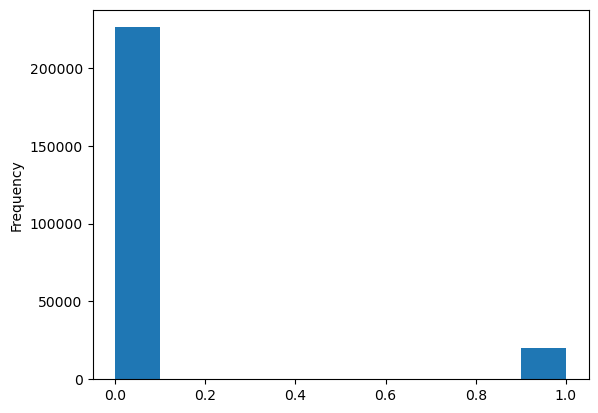

In [5]:
print(os.listdir(root_data))
app_train = execution_environment.load(root_data + '/application_train.csv')
print('Training data shape: ', app_train.shape().data())
app_train.head().data()

app_test = execution_environment.load(root_data + '/application_test.csv')
print('Testing data shape: ', app_test.shape().data())
app_test.head().data()

test_labels = execution_environment.load(root_data + '/application_test_labels.csv')

app_train['TARGET'].value_counts().data()

app_train['TARGET'].data().astype(int).plot.hist()

## Examine Missing Values

In [6]:
# Function to calculate missing values by column# Funct
def missing_values_table(dataset):
    # Total missing values
    mis_val = dataset.isnull().sum().data()

    mis_val_percent = 100 * mis_val / len(dataset.data())

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(dataset.shape().data()[1]) + " columns.\n"
                                                                                   "There are " + str(
        mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 66 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,171963,69.9
COMMONAREA_AVG,171963,69.9
COMMONAREA_MODE,171963,69.9
NONLIVINGAPARTMENTS_MEDI,170916,69.5
NONLIVINGAPARTMENTS_MODE,170916,69.5
NONLIVINGAPARTMENTS_AVG,170916,69.5
FONDKAPREMONT_MODE,168303,68.4
LIVINGAPARTMENTS_MODE,168254,68.4
LIVINGAPARTMENTS_MEDI,168254,68.4
LIVINGAPARTMENTS_AVG,168254,68.4


In [7]:
app_train.dtypes().data().value_counts()
app_train.select_dtypes('object').nunique().data()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

## Encoding Categorical Variables

In [8]:
from experiment_graph.sklearn_helper.preprocessing import LabelEncoder
# Create a label encoder object
le_count = 0

columns = app_train.select_dtypes('object').data().columns
for col in columns:
    # we are not using nunique because it discard nan
    if app_train[col].nunique(dropna=False).data() <= 2:
        le = LabelEncoder()
        le.fit(app_train[col])

        app_train = app_train.replace_columns(col, le.transform(app_train[col]))
        app_test = app_test.replace_columns(col, le.transform(app_test[col]))

        # Keep track of how many columns were label encoded
        le_count += 1
print('%d columns were label encoded.' % le_count)
app_train.data()
app_test.data()

app_train = app_train.onehot_encode()
app_test = app_test.onehot_encode()

print('Training Features shape: ', app_train.shape().data())
print('Testing Features shape: ', app_test.shape().data())

3 columns were label encoded.
Training Features shape:  (246008, 246)
Testing Features shape:  (61503, 244)


## Aligning Training and Testing Data


In [9]:
train_labels = app_train['TARGET']
app_train = app_train.align(app_test)
app_test = app_test.align(app_train)

app_train = app_train.add_columns('TARGET', train_labels)

print('Training Features shape: ', app_train.shape().data())
print('Testing Features shape: ', app_test.shape().data())

Training Features shape:  (246008, 245)
Testing Features shape:  (61503, 244)


## Anomalies

The non-anomalies default on 8.63% of loans
The anomalies default on 5.41% of loans
There are 44231 anomalous days of employment
There are 11143 anomalies in the test data out of 61503 entries


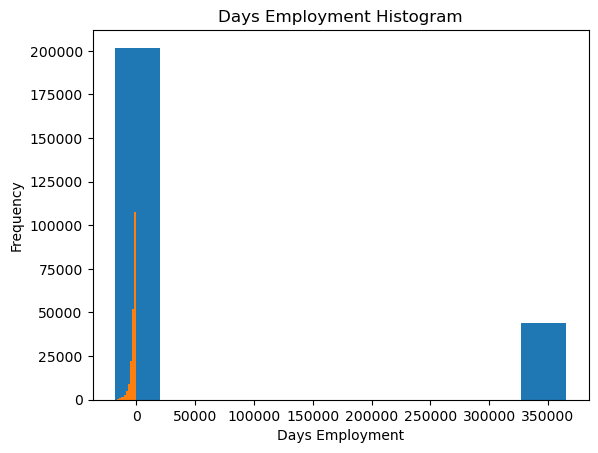

In [10]:
(app_train['DAYS_BIRTH'] / 365).describe().data()

app_train['DAYS_EMPLOYED'].describe().data()

app_train['DAYS_EMPLOYED'].data().plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean().data()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean().data()))
print('There are %d anomalous days of employment' % anom.shape().data()[0])

# Create an anomalous flag column
days_employed_anom = app_train["DAYS_EMPLOYED"] == 365243
app_train = app_train.add_columns('DAYS_EMPLOYED_ANOM', days_employed_anom)
temp = app_train['DAYS_EMPLOYED'].replace({365243: np.nan})
app_train = app_train.drop('DAYS_EMPLOYED')
app_train = app_train.add_columns('DAYS_EMPLOYED', temp)

app_train["DAYS_EMPLOYED"].data().plot.hist(title='Days Employment Histogram');
plt.xlabel('Days Employment')

days_employed_anom = app_test["DAYS_EMPLOYED"] == 365243
app_test = app_test.add_columns('DAYS_EMPLOYED_ANOM', days_employed_anom)
temp = app_test['DAYS_EMPLOYED'].replace({365243: np.nan})
app_test = app_test.drop('DAYS_EMPLOYED')
app_test = app_test.add_columns('DAYS_EMPLOYED', temp)
print('There are %d anomalies in the test data out of %d entries'
      % (app_test['DAYS_EMPLOYED_ANOM'].sum().data(),
         app_test.shape().data()[0]))

## Correlations


In [11]:
# correlations = app_train.corr().data()
# top = correlations['TARGET'].sort_values()
# # Display correlations
# print('Most Positive Correlations:\n', top.tail(15))
# print('\nMost Negative Correlations:\n', top.head(15)) 

## Effect of Age on Repayment 

Text(0.5, 1.0, 'Failure to Repay by Age Group')

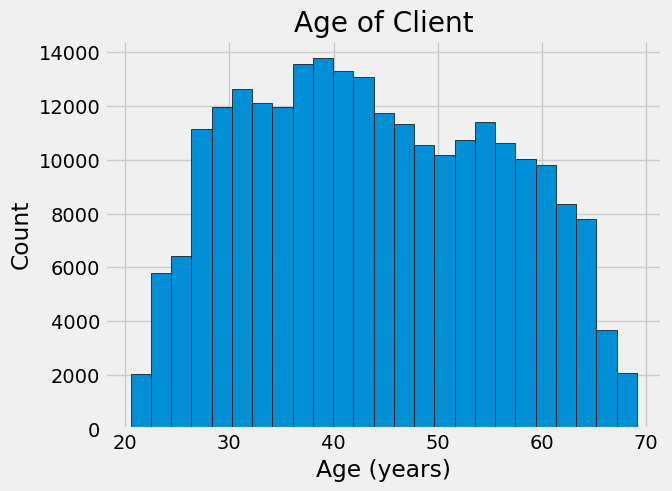

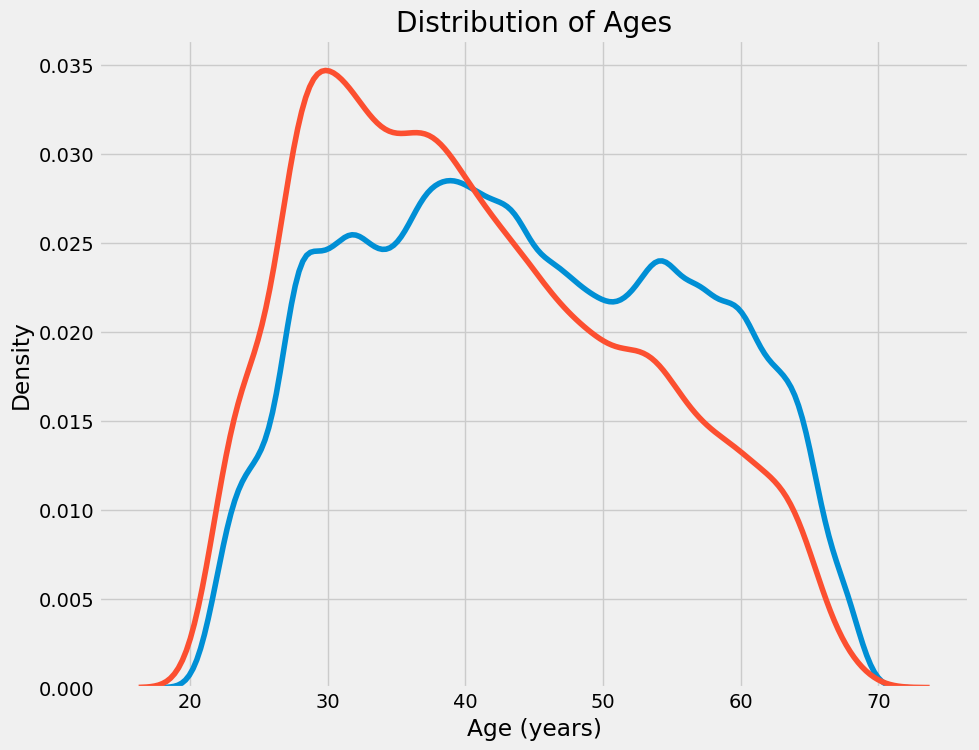

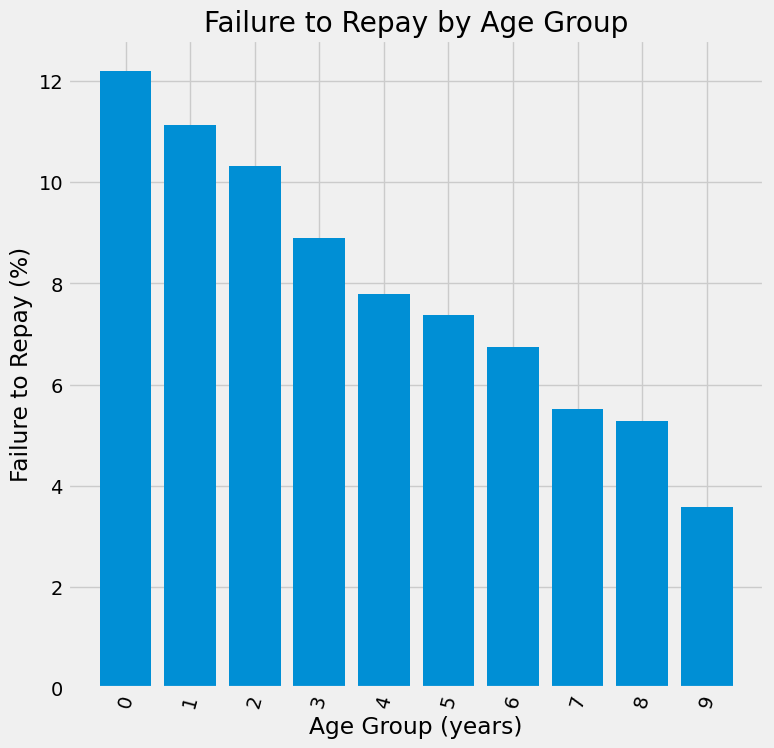

In [12]:
abs_age = app_train['DAYS_BIRTH'].abs()
app_train = app_train.drop('DAYS_BIRTH')
app_train = app_train.add_columns('DAYS_BIRTH', abs_age)
app_train['DAYS_BIRTH'].corr(app_train['TARGET']).data()

# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist((app_train['DAYS_BIRTH'] / 365).data(), edgecolor='k', bins=25)
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count')

plt.figure(figsize=(10, 8))
# KDE plot of loans that were repaid on time
sns.kdeplot((app_train[app_train['TARGET'] == 0]['DAYS_BIRTH'] / 365).data(), label='target == 0')
# KDE plot of loans which were not repaid on time
sns.kdeplot((app_train[app_train['TARGET'] == 1]['DAYS_BIRTH'] / 365).data(), label='target == 1')
# Labeling of plot
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Distribution of Ages')

# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
years_birth = age_data['DAYS_BIRTH'] / 365
age_data = age_data.add_columns('YEARS_BIRTH', years_birth)
binned = age_data['YEARS_BIRTH'].binning(20, 70, 11)
binned.setname('YEARS_BINNED')
age_data = age_data.add_columns('YEARS_BINNED', binned)
age_data.head(10).data()

age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups.data()

plt.figure(figsize=(8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.data().index.astype(str), age_groups.data()['TARGET'] * 100)

# Plot labeling
plt.xticks(rotation=75)
plt.xlabel('Age Group (years)')
plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group')

## Exterior Sources

/Users/rishabhmac/Documents/GitHub/ml-workload-optimization/code/collaborative-optimizer/experiment_graph/graph/node.py:1576: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  self.nodes[0].get_materialized_data()[
/Users/rishabhmac/Documents/GitHub/ml-workload-optimization/code/collaborative-optimizer/experiment_graph/graph/node.py:1576: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  self.nodes[0].get_materialized_data()[
/Users/rishabhmac/Documents/GitHub/ml-workload-optimization/code/collaborative-optimizer/experiment_graph/graph/node.py:1576: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  self.nodes[0].get_materialized_data()[
/Users/rishabhmac/Documents/GitHub/ml-workload-optimization/code/collaborative-optimizer/experiment_graph/graph/node.py:1576: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  self.nodes[0].get_materialized_data()[
/Users/rishabhmac/Documents/

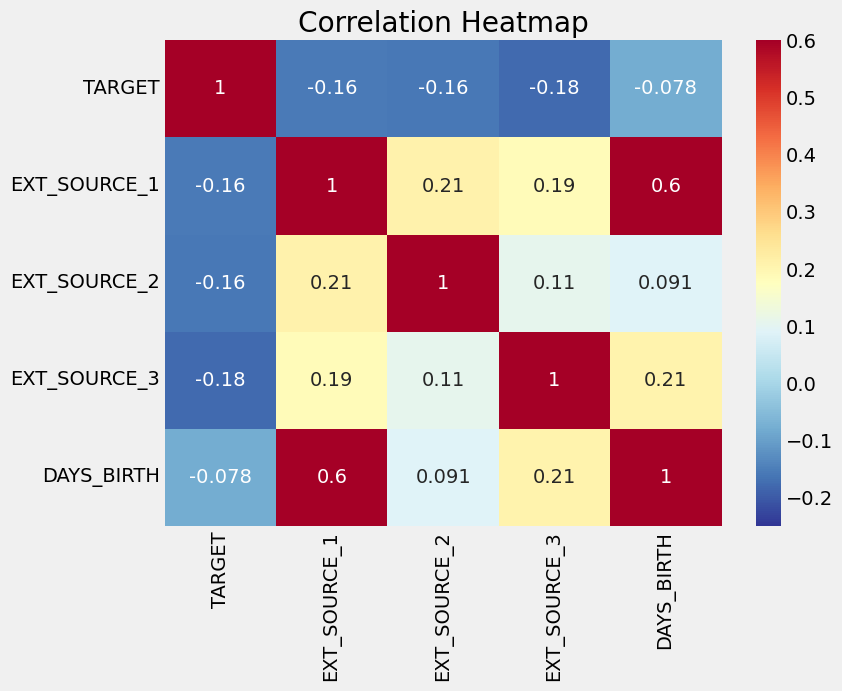

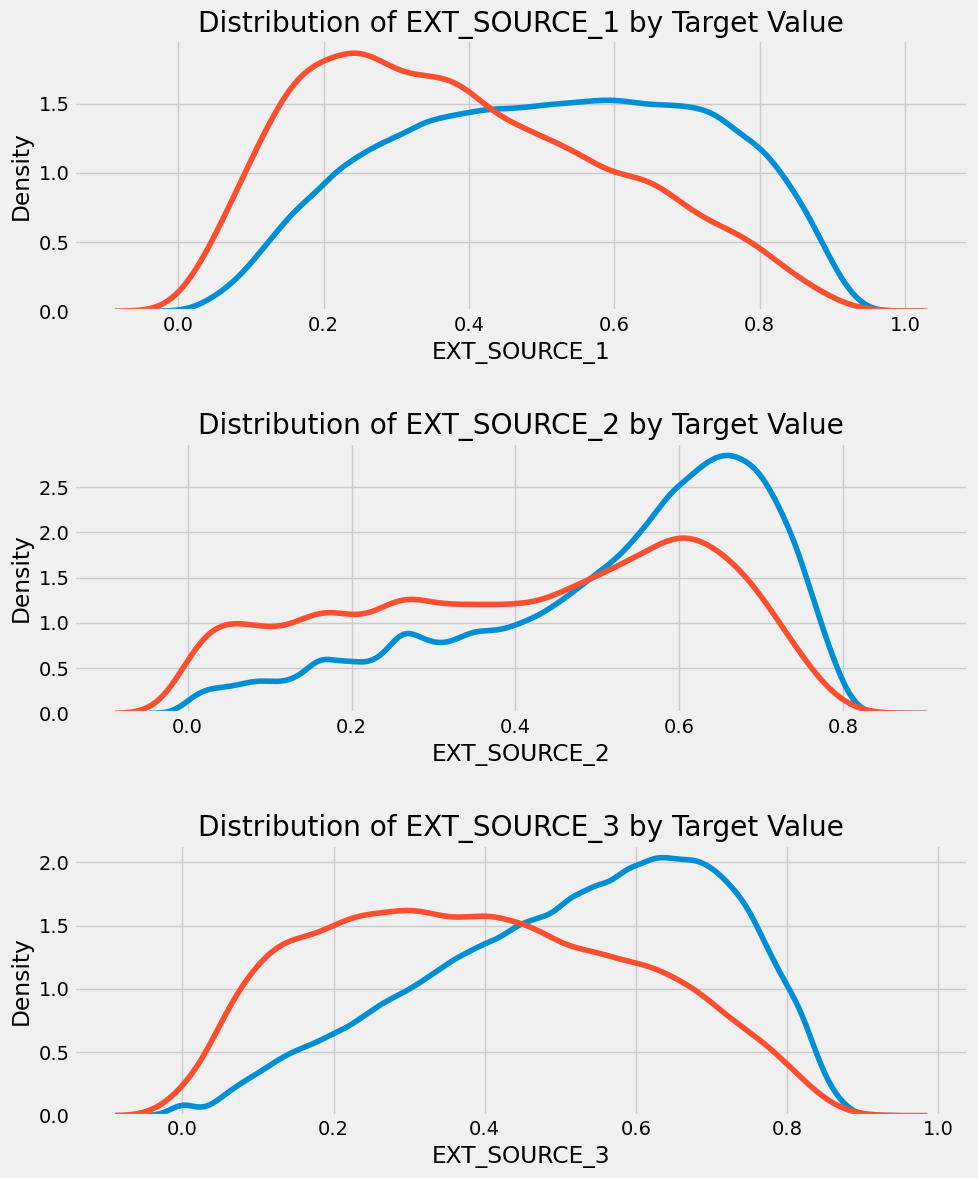

In [13]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr().data()

plt.figure(figsize=(8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap')

plt.figure(figsize=(10, 12))

# iterate through the sources
for i, column in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    source_data = app_train[[column, 'TARGET']][app_train['TARGET'] == 0]
    sns.kdeplot(source_data[app_train[column].notna()][column].data(), label='target == 0')
    # plot loans that were not repaid
    source_data = app_train[[column, 'TARGET']][app_train['TARGET'] == 1]
    sns.kdeplot(source_data[app_train[column].notna()][column].data(), label='target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % column)
    plt.xlabel('%s' % column)
    plt.ylabel('Density')

plt.tight_layout(h_pad=2.5)

## Pairs Plot

/Users/rishabhmac/opt/anaconda3/envs/mlflow/lib/python3.8/site-packages/seaborn/axisgrid.py:1209: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
/Users/rishabhmac/opt/anaconda3/envs/mlflow/lib/python3.8/site-packages/seaborn/distributions.py:1163: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/rishabhmac/opt/anaconda3/envs/mlflow/lib/python3.8/site-packages/seaborn/distributions.py:1163: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/rishabhmac/opt/anaconda3/envs/mlflow/lib/python3.8/site-packages/seaborn/distributions.py:1163: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/rishabhmac/opt/anaconda3/envs/mlflow/lib/python3.8/site-packages/seaborn/distributions.py:1163: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, User

Text(0.5, 1.05, 'Ext Source and Age Features Pairs Plot')

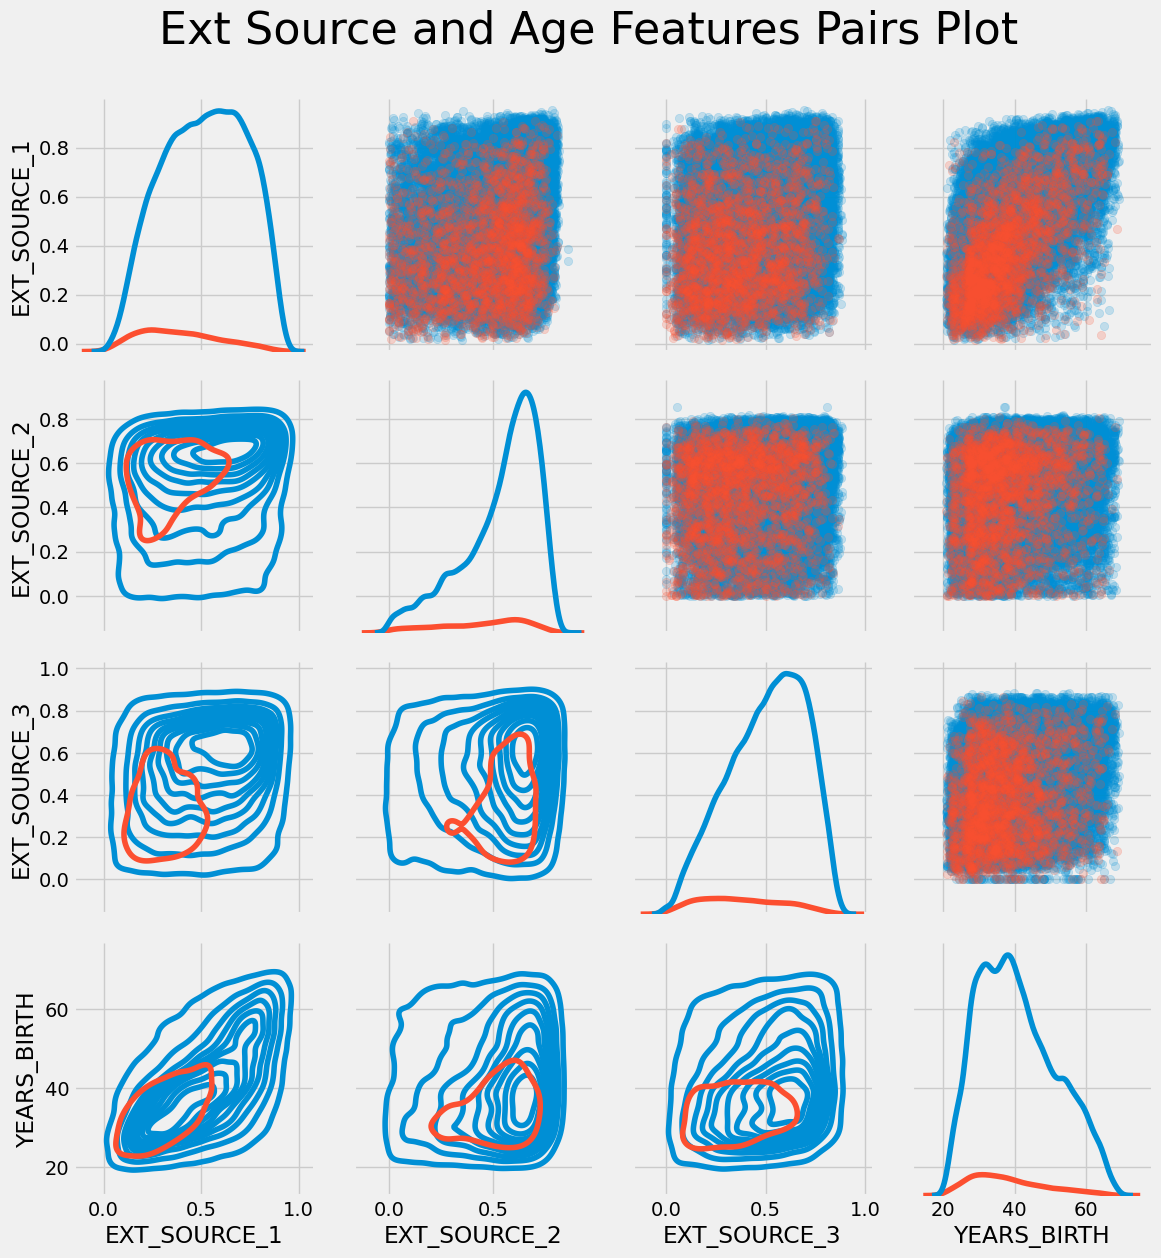

In [14]:
# Copy the data for plotting
plot_data = ext_data.drop('DAYS_BIRTH')

# Add in the age of the client in years
plot_data = plot_data.add_columns('YEARS_BIRTH', age_data['YEARS_BIRTH'])
# Drop na values and limit to first 100000 rows
plot_data = plot_data.head(100000).dropna()

# Create the pair grid object
grid = sns.PairGrid(data=plot_data.data(), size=3, diag_sharey=False,
                    hue='TARGET',
                    vars=[x for x in list(plot_data.data().columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha=0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap=plt.cm.OrRd_r)

plt.suptitle('Ext Source and Age Features Pairs Plot', size=32, y=1.05)

## Feature Engineering

In [15]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from experiment_graph.sklearn_helper.preprocessing import Imputer

imputer = Imputer(strategy='median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns=['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from experiment_graph.sklearn_helper.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree=3)

# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape().data())

new_names = poly_transformer.get_feature_names(input_features=['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                                               'EXT_SOURCE_3', 'DAYS_BIRTH'])
# new_names = poly_transformer.get_feature_names_out(input_features=['EXT_SOURCE_1', 'EXT_SOURCE_2',
#                                                                'EXT_SOURCE_3', 'DAYS_BIRTH'])

poly_features = poly_features.set_columns(new_names)

# Add in the target
poly_features = poly_features.add_columns('TARGET', poly_target)

# Find the correlations with the target
poly_corrs = poly_features.corr().data()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

poly_features_test = poly_features_test.set_columns(new_names)

# Merge polynomial features into training dataframe
poly_features = poly_features.add_columns('SK_ID_CURR', app_train['SK_ID_CURR'])
app_train_poly = app_train.merge(poly_features, on='SK_ID_CURR', how='left')

# Merge polnomial features into testing dataframe
poly_features_test = poly_features_test.add_columns('SK_ID_CURR', app_test['SK_ID_CURR'])
app_test_poly = app_test.merge(poly_features_test, on='SK_ID_CURR', how='left')

# Align the dataframes
app_train_poly = app_train_poly.align(app_test_poly)
app_test_poly = app_test_poly.align(app_train_poly)

# Print out the new shapes
print('Training data with polynomial features shape: ',
      app_train_poly.shape().data())
print('Testing data with polynomial features shape:  ',
      app_test_poly.shape().data())

Polynomial Features shape:  (246008, 35)
EXT_SOURCE_2 EXT_SOURCE_3                -0.193054
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189392
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.180528
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.175233
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.171844
EXT_SOURCE_1 EXT_SOURCE_2                -0.166327
EXT_SOURCE_1 EXT_SOURCE_3                -0.164718
EXT_SOURCE_2                             -0.158998
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156229
EXT_SOURCE_3                             -0.156006
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078175
DAYS_BIRTH^2   -0.076627
DAYS_BIRTH^3   -0.074246
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64
Training data with polynomial features shape:  (246008, 280)
Testing data with polynomial features shape:   (61503, 280)


## Domain Knowledge Features

In [16]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain = app_train_domain.add_columns('CREDIT_INCOME_PERCENT',
                                                app_train_domain['AMT_CREDIT'] / app_train_domain[
                                                    'AMT_INCOME_TOTAL'])
app_train_domain = app_train_domain.add_columns('ANNUITY_INCOME_PERCENT',
                                                app_train_domain['AMT_ANNUITY'] / app_train_domain[
                                                    'AMT_INCOME_TOTAL'])
app_train_domain = app_train_domain.add_columns('CREDIT_TERM',
                                                app_train_domain['AMT_ANNUITY'] / app_train_domain[
                                                    'AMT_CREDIT'])
app_train_domain = app_train_domain.add_columns('DAYS_EMPLOYED_PERCENT',
                                                app_train_domain['DAYS_EMPLOYED'] / app_train_domain[
                                                    'DAYS_BIRTH'])

app_test_domain = app_test_domain.add_columns('CREDIT_INCOME_PERCENT',
                                              app_test_domain['AMT_CREDIT'] / app_test_domain[
                                                  'AMT_INCOME_TOTAL'])
app_test_domain = app_test_domain.add_columns('ANNUITY_INCOME_PERCENT',
                                              app_test_domain['AMT_ANNUITY'] / app_test_domain[
                                                  'AMT_INCOME_TOTAL'])
app_test_domain = app_test_domain.add_columns('CREDIT_TERM',
                                              app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT'])
app_test_domain = app_test_domain.add_columns('DAYS_EMPLOYED_PERCENT',
                                              app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH'])

In [17]:
# if 'TARGET' in columns:
#     train = app_train.drop(columns=['TARGET'])
# else:
#     train = app_train.copy()

# columns_train = list(train.data().columns)
# columns_test = list(app_test.data().columns)

In [18]:
# len(columns_train)

In [19]:
# len(columns_test)

In [20]:
# # columns_train == columns_test
# for x, y in zip((columns_train), (columns_test)):
#     if x != y:
#         print(x + " " + y)

## Baseline

In [21]:
from experiment_graph.sklearn_helper.preprocessing import MinMaxScaler

# Drop the target from the training data
columns = app_train.data().columns
if 'TARGET' in columns:
    train = app_train.drop(columns=['TARGET'])
else:
    train = app_train.copy()

# Feature names
features = list(train.data().columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = Imputer(strategy='median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
# imputer.fit(train)
imputer.fit(train[features])

# Transform both training and testing data
# train = imputer.transform(train)
# test = imputer.transform(test)

train = imputer.transform(train[features])
test = imputer.transform(test[features])

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape().data())
print('Testing data shape: ', test.shape().data())

from experiment_graph.sklearn_helper.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C=0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

score = log_reg.score(test,
                      test_labels['TARGET'],
                      score_type='auc').data()
print('Logistic Regression with AUC score: {}'.format(score))

Training data shape:  (246008, 245)
Testing data shape:  (61503, 245)
Logistic Regression with AUC score: {'auc': 0.6850336328387496}


## Improved Model: Random Forest

In [22]:
from experiment_graph.sklearn_helper.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)

# Train on the training data
random_forest.fit(train, train_labels)

# Extract feature importance
feature_importances = random_forest.feature_importances(features)

score = random_forest.score(test,
                            test_labels['TARGET'],
                            score_type='auc').data()
print('Random Forest Simple Data with AUC score: {}'.format(score))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s


Random Forest Simple Data with AUC score: {'auc': 0.6945228654228155}


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


## Make Predictions using Engineered Features

In [23]:
# poly_features_names_train = list(app_train_poly.data().columns)
# poly_features_names_test = list(app_test_poly.data().columns)
# print(len(poly_features_names_train))
# print(len(poly_features_names_test))
# for x, y in zip((poly_features_names_train), (poly_features_names_test)):
#     if x != y:
#         print(x + " " + y)

In [24]:
poly_features_names = list(app_train_poly.data().columns)

# Impute the polynomial features
imputer2 = Imputer(strategy='median')

# imputer2.fit(app_train_poly)
imputer2.fit(app_train_poly[poly_features_names])

# app_train_poly = imputer2.transform(app_train_poly)
# app_test_poly = imputer2.transform(app_test_poly)
app_train_poly = imputer2.transform(app_train_poly[poly_features_names])
app_test_poly = imputer2.transform(app_test_poly[poly_features_names])

# Scale the polynomial features
scaler = MinMaxScaler(feature_range=(0, 1))

app_train_poly = scaler.fit_transform(app_train_poly)
app_test_poly = scaler.transform(app_test_poly)

print('Training data shape: ', app_train_poly.shape().data())
print('Testing data shape: ', app_test_poly.shape().data())


random_forest_poly = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)
random_forest_poly.fit(app_train_poly, train_labels)


# score = random_forest_poly.score(app_test_poly,
score = random_forest_poly.score(app_test_poly,
                                 test_labels['TARGET'],
                                 score_type='auc').data()
print('Random Forest Poly Data with AUC score: {}'.format(score))

Training data shape:  (246008, 280)
Testing data shape:  (61503, 280)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   41.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Random Forest Poly Data with AUC score: {'auc': 0.6602014318780794}


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished


## Testing Domain Features

In [25]:
app_train_domain = app_train_domain.drop(columns='TARGET')

domain_features_names = list(app_train_domain.data().columns)

# Impute the domainnomial features
imputer = Imputer(strategy='median')

# domain_features = imputer.fit_transform(app_train_domain)
# domain_features_test = imputer.transform(app_test_domain)
domain_features = imputer.fit_transform(app_train_domain[domain_features_names])
domain_features_test = imputer.transform(app_test_domain[domain_features_names])

# Scale the domainnomial features
scaler = MinMaxScaler(feature_range=(0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

# Train on the training data
random_forest_domain = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)
random_forest_domain.fit(domain_features, train_labels)

# Extract feature importances
feature_importances_domain = random_forest_domain.feature_importances(domain_features_names)

score = random_forest_domain.score(domain_features_test,
                                   test_labels['TARGET'],
                                   score_type='auc').data()
print('Random Forest Domain Data with AUC score: {}'.format(score))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s


Random Forest Domain Data with AUC score: {'auc': 0.6983929271811882}


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


## PLOT

In [26]:
import copy
from collections import deque
from datetime import datetime

import networkx as nx
import numpy as np

# Reserved word for representing super graph.
# Do not use combine as an operation name
# TODO: make file with all the global names
from experiment_graph.graph.auxilary import DataFrame, DataSeries
from experiment_graph.data_storage import SimpleStorageManager
from experiment_graph.globals import COMBINE_OPERATION_IDENTIFIER

def plot_graph_input(graph_input, plt, figsize=(12, 12), labels_for_vertex=['size'], labels_for_edges=['name'], vertex_size=1000,
                   vertex_font_size=10):
        """
        plot the graph using the graphvix dot layout
        :param vertex_font_size:
        :param vertex_size:
        :param labels_for_edges:
        :param labels_for_vertex:
        :param figsize: size of the figure (default (12,12))
        :param plt: matlibplot object
        """
        from networkx.drawing.nx_agraph import graphviz_layout
        f = plt.figure(figsize=figsize)
        ax = f.add_subplot(1, 1, 1)
        pos = graphviz_layout(graph_input.graph, prog='dot', args='')

        # get the list of available types and frequency of each node
        vertex_labels = {}
        unique_types = []

        for node in graph_input.graph.nodes(data=True):
            if node[1]['type'] not in unique_types:
                unique_types.append(node[1]['type'])
            labels = []
            for p in labels_for_vertex:

                if p == 'id':
                    if node[1]['root']:
                        labels.append('root')
                    else:
                        labels.append(node[0][:10])
                if p not in node[1]:
                    labels.append('-')
                elif type(node[1][p]) is np.float64 or type(node[1][p]) is float:
                    labels.append('{:.3f}'.format(node[1][p]))
                else:
                    labels.append(str(node[1][p]))

            vertex_labels[node[0]] = ','.join(labels)

        jet = plt.get_cmap('gist_rainbow')
        colors = jet(np.linspace(0, 1, len(unique_types)))
        color_map = dict(zip(unique_types, colors))
        for label in color_map:
            ax.scatter(None, None, color=color_map[label], label=label)

        # TODO there's a problem with nodelist=...., the node type and legends dont match
        # materialized_nodes = [n[0] for n in graph_input.graph.node(data='mat') if n[1]]
        materialized_nodes = [n[0] for n in graph_input.graph.nodes(data='mat') if n[1]]
        # all_colors = [color_map[n[1]['type']] for n in graph_input.graph.nodes(data=True) if n[1]['mat']]
        all_colors = [color_map[n[1]['type']] for n in graph_input.graph.nodes(data=True) if 'mat' in n[1]]
        nx.draw_networkx(
            graph_input.graph,
            node_size=vertex_size,
            nodelist=materialized_nodes,
            cmap=jet,
            # vmin=0,
            # vmax=len(unique_types),
            node_color=all_colors,
            node_shape='s',
            pos=pos,
            with_labels=False,
            ax=ax)

        # non_materialized_nodes = [n[0] for n in graph_input.graph.node(data='mat') if not n[1]]
        non_materialized_nodes = [n[0] for n in graph_input.graph.nodes(data='mat') if not n[1]]
        # all_colors = [color_map[n[1]['type']] for n in graph_input.graph.nodes(data=True) if not n[1]['mat']]
        all_colors = [color_map[n[1]['type']] for n in graph_input.graph.nodes(data=True) if 'mat' not in n[1]]
        nx.draw_networkx(
            graph_input.graph,
            edgelist=[],
            node_size=vertex_size,
            nodelist=non_materialized_nodes,
            cmap=jet,
            # vmin=0,
            # vmax=len(unique_types),
            node_color=all_colors,
            node_shape='o',
            pos=pos,
            with_labels=False,
            ax=ax)

        if labels_for_vertex:
            nx.draw_networkx_labels(graph_input.graph,
                                    pos=pos,
                                    labels=vertex_labels,
                                    font_size=vertex_font_size)

        def construct_label(edge_data, edge_labels):
            return ','.join(['' if str(edge_data[l]) == 'combine' else str(edge_data[l]) for l in edge_labels])

        nx.draw_networkx_edge_labels(
            graph_input.graph,
            pos=pos,
            edge_labels={(u, v): construct_label(d, labels_for_edges) for u, v, d in graph_input.graph.edges(data=True)})

        plt.axis('off')
        f.set_facecolor('w')
        leg = ax.legend(markerscale=4, loc='best', fontsize=12, scatterpoints=1)

        for line in leg.get_lines():
            line.set_linewidth(4.0)


## Workload DAG Plot

In [27]:
# import importlib
# import experiment_graph.graph.graph_representations
# from experiment_graph.graph.graph_representations import WorkloadDag, ExperimentGraph
# importlib.reload(experiment_graph.graph.graph_representations)
# importlib.reload(experiment_graph.execution_environment)

In [28]:
# import sys
# del sys.modules['experiment_graph.execution_environment']
# del sys.modules['experiment_graph.graph.graph_representations']

In [29]:
# from experiment_graph.execution_environment import ExecutionEnvironment
# from experiment_graph.graph.graph_representations import WorkloadDag, ExperimentGraph

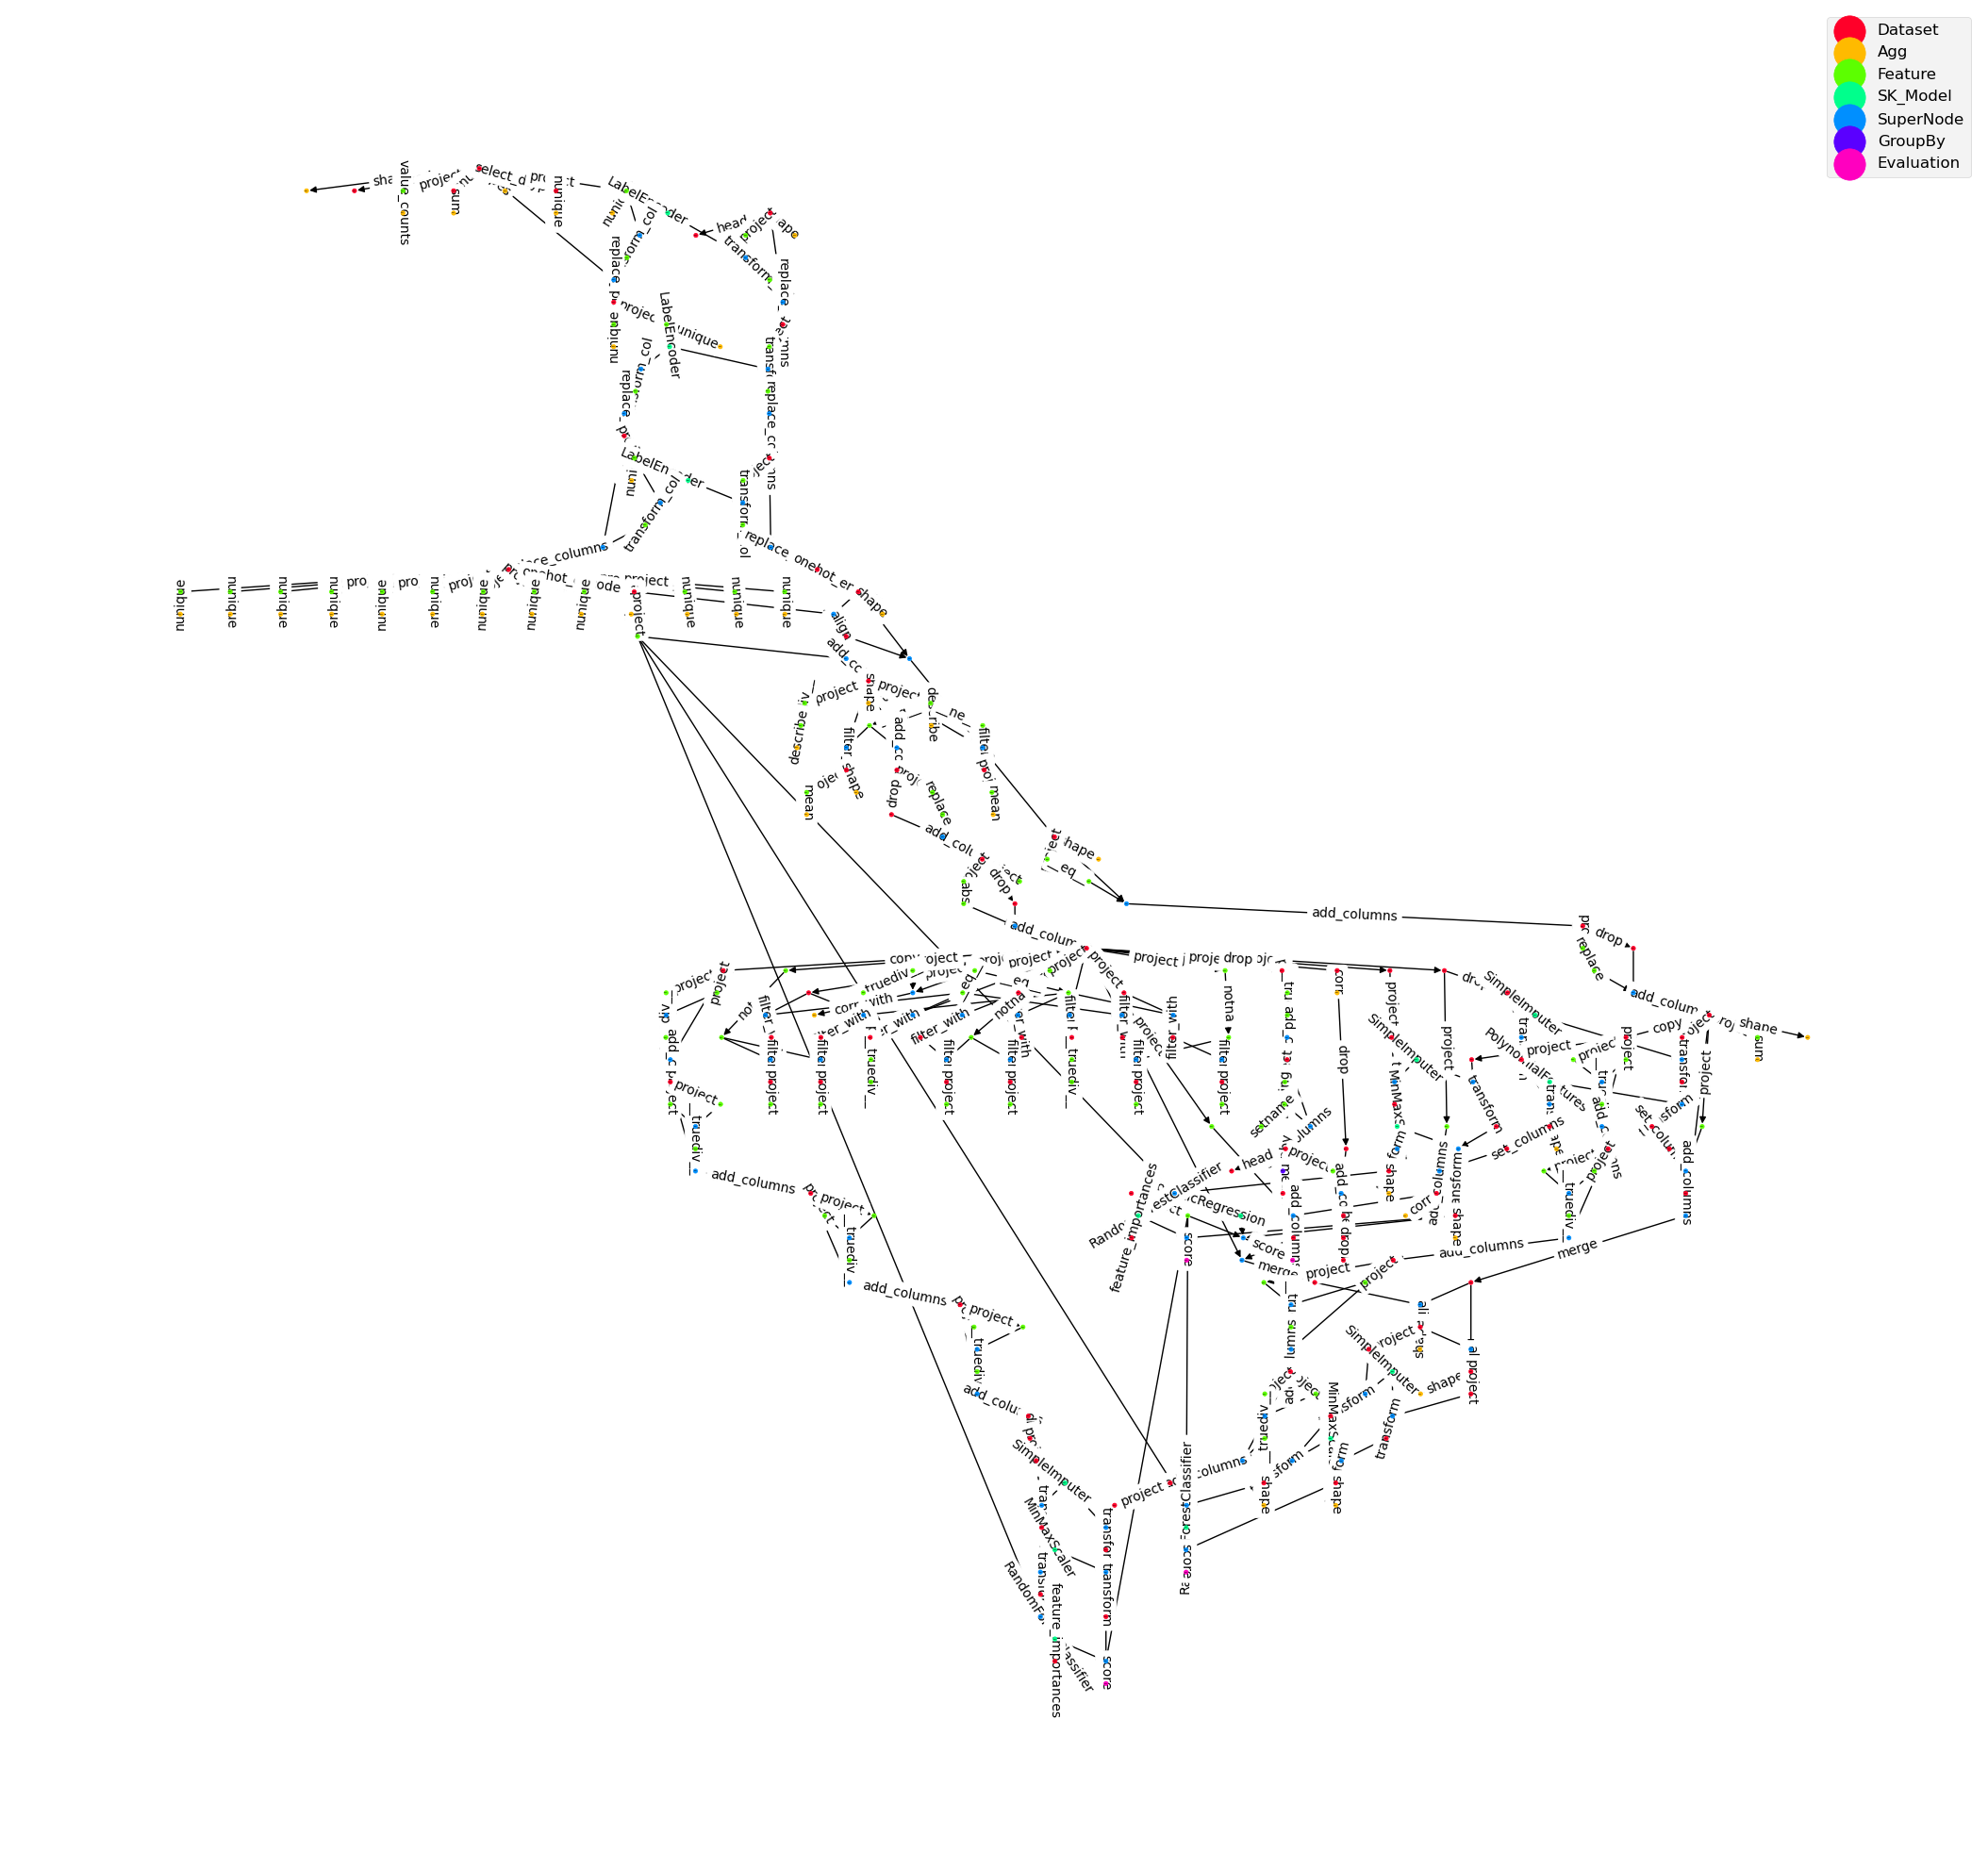

In [30]:
execution_environment.workload_dag.plot_graph(plt, vertex_size=10, figsize=(24, 24), vertex_font_size=0)

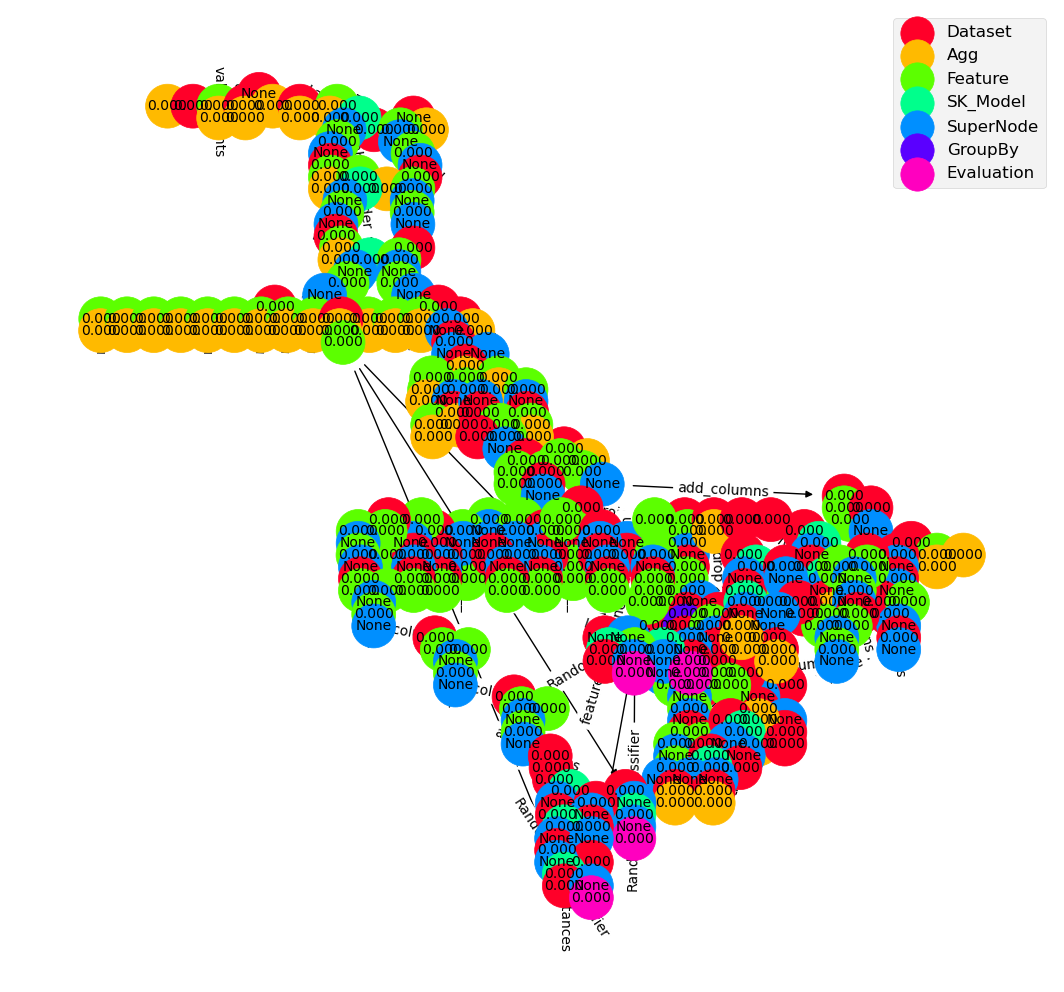

In [31]:
plot_graph_input(execution_environment.workload_dag, plt)

## Experiement Graph Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


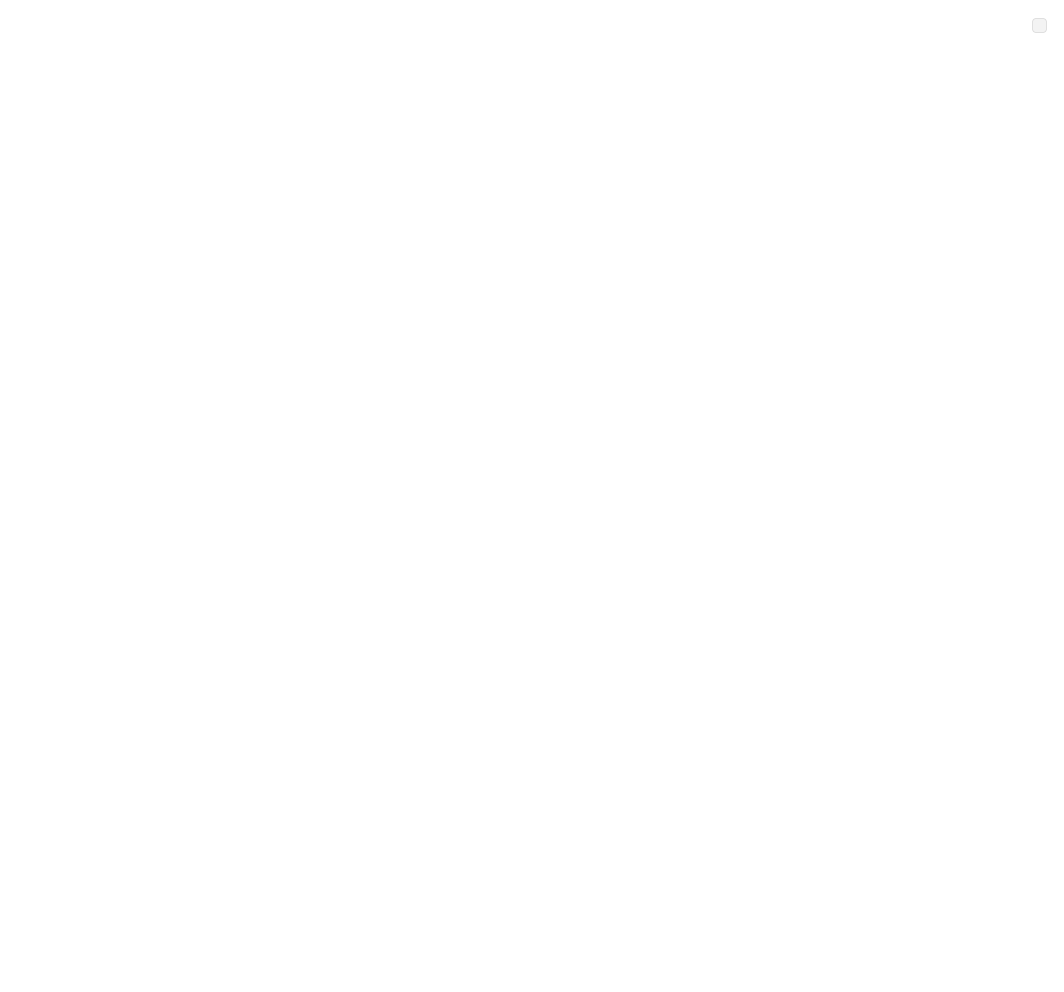

In [32]:
execution_environment.experiment_graph.plot_graph(plt)

In [33]:
# execution_environment.test_function()

In [34]:
# import importlib
# import experiment_graph.graph.graph_representations
# from experiment_graph.graph.graph_representations import WorkloadDag, ExperimentGraph
# importlib.reload(experiment_graph.graph.graph_representations)
# importlib.reload(experiment_graph.execution_environment)

In [35]:
node_labels = list(execution_environment.workload_dag.graph.nodes(data=True))
print(len(node_labels))
print(node_labels)

351
[('application_train.csv{}', {'root': True, 'type': 'Dataset', 'data': <experiment_graph.graph.node.Dataset object at 0x7fd5b20c7580>, 'loc': './data/final/application_train.csv', 'extra_params': {}, 'size': None}), ('4A3F3862EC3739B17293F6C0469C4825', {'type': 'Agg', 'root': False, 'data': <experiment_graph.graph.node.Agg object at 0x7fd5e0a57550>, 'size': 0.0}), ('51706642912947F8FE42884FC3D178EC', {'type': 'Dataset', 'root': False, 'data': <experiment_graph.graph.node.Dataset object at 0x7fd5e08f1b80>, 'size': 0.0}), ('application_test.csv{}', {'root': True, 'type': 'Dataset', 'data': <experiment_graph.graph.node.Dataset object at 0x7fd5b20c7eb0>, 'loc': './data/final/application_test.csv', 'extra_params': {}, 'size': None}), ('86CFD76958926538A85C44814257E4D9', {'type': 'Agg', 'root': False, 'data': <experiment_graph.graph.node.Agg object at 0x7fd5e0a573a0>, 'size': 0.0}), ('AF81475B28FC81FF5FDA3450B04F83B8', {'type': 'Dataset', 'root': False, 'data': <experiment_graph.graph.no

In [36]:
all_dicts = [tup[1] for tup in node_labels]
all_dicts

[{'root': True,
  'type': 'Dataset',
  'data': <experiment_graph.graph.node.Dataset at 0x7fd5b20c7580>,
  'loc': './data/final/application_train.csv',
  'extra_params': {},
  'size': None},
 {'type': 'Agg',
  'root': False,
  'data': <experiment_graph.graph.node.Agg at 0x7fd5e0a57550>,
  'size': 0.0},
 {'type': 'Dataset',
  'root': False,
  'data': <experiment_graph.graph.node.Dataset at 0x7fd5e08f1b80>,
  'size': 0.0},
 {'root': True,
  'type': 'Dataset',
  'data': <experiment_graph.graph.node.Dataset at 0x7fd5b20c7eb0>,
  'loc': './data/final/application_test.csv',
  'extra_params': {},
  'size': None},
 {'type': 'Agg',
  'root': False,
  'data': <experiment_graph.graph.node.Agg at 0x7fd5e0a573a0>,
  'size': 0.0},
 {'type': 'Dataset',
  'root': False,
  'data': <experiment_graph.graph.node.Dataset at 0x7fd5aa922df0>,
  'size': 0.0},
 {'root': True,
  'type': 'Dataset',
  'data': <experiment_graph.graph.node.Dataset at 0x7fd5b20e1790>,
  'loc': './data/final/application_test_labels.cs

In [37]:
from itertools import chain
list(set(chain.from_iterable(sub.keys() for sub in all_dicts)))

['type',
 'extra_params',
 'score',
 'root',
 'involved_nodes',
 'data',
 'size',
 'loc']

In [38]:
list(execution_environment.workload_dag.graph.nodes(data=True))

[('application_train.csv{}',
  {'root': True,
   'type': 'Dataset',
   'data': <experiment_graph.graph.node.Dataset at 0x7fd5b20c7580>,
   'loc': './data/final/application_train.csv',
   'extra_params': {},
   'size': None}),
 ('4A3F3862EC3739B17293F6C0469C4825',
  {'type': 'Agg',
   'root': False,
   'data': <experiment_graph.graph.node.Agg at 0x7fd5e0a57550>,
   'size': 0.0}),
 ('51706642912947F8FE42884FC3D178EC',
  {'type': 'Dataset',
   'root': False,
   'data': <experiment_graph.graph.node.Dataset at 0x7fd5e08f1b80>,
   'size': 0.0}),
 ('application_test.csv{}',
  {'root': True,
   'type': 'Dataset',
   'data': <experiment_graph.graph.node.Dataset at 0x7fd5b20c7eb0>,
   'loc': './data/final/application_test.csv',
   'extra_params': {},
   'size': None}),
 ('86CFD76958926538A85C44814257E4D9',
  {'type': 'Agg',
   'root': False,
   'data': <experiment_graph.graph.node.Agg at 0x7fd5e0a573a0>,
   'size': 0.0}),
 ('AF81475B28FC81FF5FDA3450B04F83B8',
  {'type': 'Dataset',
   'root': Fal

In [39]:
# list(execution_environment.workload_dag.graph.nodes(data=True))[0][1]['data'].compute_size()

In [40]:
all_edges = list(execution_environment.workload_dag.graph.edges(data=True))
all_edges

[('application_train.csv{}',
  '4A3F3862EC3739B17293F6C0469C4825',
  {'name': 'shape',
   'oper': 'p_shape',
   'execution_time': 0.023,
   'executed': True,
   'args': {},
   'hash': 'shape({})',
   'freq': 2}),
 ('application_train.csv{}',
  '51706642912947F8FE42884FC3D178EC',
  {'name': 'head',
   'oper': 'p_head',
   'execution_time': 1.249,
   'executed': True,
   'args': {'size': 5},
   'hash': "head({'size':5})",
   'freq': 1}),
 ('application_train.csv{}',
  '885517FA12002C9EFFCF2618E23CEB6C',
  {'name': 'project',
   'execution_time': 0.668,
   'executed': True,
   'oper': 'p_project',
   'args': {'columns': 'TARGET'},
   'hash': "project({'columns':'TARGET'})",
   'freq': 2}),
 ('application_train.csv{}',
  '6AABC0FEF0CC9CEE313FEE2F88BCD237',
  {'name': 'isnull',
   'oper': 'p_isnull',
   'execution_time': 485.379,
   'executed': True,
   'args': {},
   'hash': 'isnull({})',
   'freq': 1}),
 ('application_train.csv{}',
  '8FE81BE1C6C355ED19FFB628AE6160DD',
  {'name': 'dtypes'

In [41]:
node_types = list(execution_environment.workload_dag.graph.nodes(data='type'))
# print(node_types)
unq_types = []
for n_t in node_types:
    if n_t[1] not in unq_types:
        unq_types.append(n_t[1])
print(len(unq_types))
print(unq_types)

7
['Dataset', 'Agg', 'Feature', 'SK_Model', 'SuperNode', 'GroupBy', 'Evaluation']


In [42]:
node_matz = list(execution_environment.workload_dag.graph.nodes(data='mat'))
node_matz

[('application_train.csv{}', None),
 ('4A3F3862EC3739B17293F6C0469C4825', None),
 ('51706642912947F8FE42884FC3D178EC', None),
 ('application_test.csv{}', None),
 ('86CFD76958926538A85C44814257E4D9', None),
 ('AF81475B28FC81FF5FDA3450B04F83B8', None),
 ('application_test_labels.csv{}', None),
 ('885517FA12002C9EFFCF2618E23CEB6C', None),
 ('5F1A78DEF5005C37A39167096883035E', None),
 ('6AABC0FEF0CC9CEE313FEE2F88BCD237', None),
 ('D882E2920B99DDB0F79170CBE49FAFF2', None),
 ('8FE81BE1C6C355ED19FFB628AE6160DD', None),
 ('4A9051542EFEE7ABF753FC9FCCDA313A', None),
 ('B351F3B87011FBF5D50EE1C70EA15AF5', None),
 ('588E87EA4494D973E7E1D3023591BA38', None),
 ('A9D4A852BBDF071D0E5D7959776FB912', None),
 ('F13A2DFB53C34E32C46DC838742E2986', None),
 ('FA654CB3ED7222EAC6EE5DEC13CEBF49', None),
 ('421BD661A585C601515158BB06A45BCE', None),
 ('4E69A269AC50EEC80A57B091735166E8', None),
 ('8A913512570E8983D000A65D2B2D411E', None),
 ('BD02967EB777DC7E336E954143A58BFC', None),
 ('87015497EC904E1014EFC760297AE

In [43]:
node_roots = list(execution_environment.workload_dag.graph.nodes(data='root'))
node_roots

[('application_train.csv{}', True),
 ('4A3F3862EC3739B17293F6C0469C4825', False),
 ('51706642912947F8FE42884FC3D178EC', False),
 ('application_test.csv{}', True),
 ('86CFD76958926538A85C44814257E4D9', False),
 ('AF81475B28FC81FF5FDA3450B04F83B8', False),
 ('application_test_labels.csv{}', True),
 ('885517FA12002C9EFFCF2618E23CEB6C', False),
 ('5F1A78DEF5005C37A39167096883035E', False),
 ('6AABC0FEF0CC9CEE313FEE2F88BCD237', False),
 ('D882E2920B99DDB0F79170CBE49FAFF2', False),
 ('8FE81BE1C6C355ED19FFB628AE6160DD', False),
 ('4A9051542EFEE7ABF753FC9FCCDA313A', False),
 ('B351F3B87011FBF5D50EE1C70EA15AF5', False),
 ('588E87EA4494D973E7E1D3023591BA38', False),
 ('A9D4A852BBDF071D0E5D7959776FB912', False),
 ('F13A2DFB53C34E32C46DC838742E2986', False),
 ('FA654CB3ED7222EAC6EE5DEC13CEBF49', False),
 ('421BD661A585C601515158BB06A45BCE', False),
 ('4E69A269AC50EEC80A57B091735166E8', False),
 ('8A913512570E8983D000A65D2B2D411E', False),
 ('BD02967EB777DC7E336E954143A58BFC', False),
 ('87015497EC

In [44]:
all_edges_dicts = [tup[2] for tup in all_edges]
list(set(chain.from_iterable(sub.keys() for sub in all_edges_dicts)))

['executed',
 'name',
 'should_warmstart',
 'no_random_state_model',
 'hash',
 'freq',
 'random_state',
 'execution_time',
 'warm_startable',
 'oper',
 'args']

In [45]:
all_edges

[('application_train.csv{}',
  '4A3F3862EC3739B17293F6C0469C4825',
  {'name': 'shape',
   'oper': 'p_shape',
   'execution_time': 0.023,
   'executed': True,
   'args': {},
   'hash': 'shape({})',
   'freq': 2}),
 ('application_train.csv{}',
  '51706642912947F8FE42884FC3D178EC',
  {'name': 'head',
   'oper': 'p_head',
   'execution_time': 1.249,
   'executed': True,
   'args': {'size': 5},
   'hash': "head({'size':5})",
   'freq': 1}),
 ('application_train.csv{}',
  '885517FA12002C9EFFCF2618E23CEB6C',
  {'name': 'project',
   'execution_time': 0.668,
   'executed': True,
   'oper': 'p_project',
   'args': {'columns': 'TARGET'},
   'hash': "project({'columns':'TARGET'})",
   'freq': 2}),
 ('application_train.csv{}',
  '6AABC0FEF0CC9CEE313FEE2F88BCD237',
  {'name': 'isnull',
   'oper': 'p_isnull',
   'execution_time': 485.379,
   'executed': True,
   'args': {},
   'hash': 'isnull({})',
   'freq': 1}),
 ('application_train.csv{}',
  '8FE81BE1C6C355ED19FFB628AE6160DD',
  {'name': 'dtypes'

In [47]:
# time undirected_graph = execution_environment.workload_dag.graph.to_undirected()
# undirected_graph

In [60]:
def convert_to_undirected_graph(workload_dag):
    import networkx as nx
    undirected_graph = workload_dag.graph.to_undirected()
    return undirected_graph

def get_MST_from_WorkloadDAG(undirected_graph, weight_attr="execution_time"):
    import networkx as nx
    import math
    weighted_undirected_graph = undirected_graph.copy()
    all_undir_edges = weighted_undirected_graph.edges(data=True)
    for curr_edge in all_undir_edges:
        curr_edge[2]["weight"] = -curr_edge[2].get(weight_attr, 0)
    MST = nx.minimum_spanning_tree(weighted_undirected_graph)
    return MST

In [49]:
# Runs for LONG time
undir_graph = convert_to_undirected_graph(execution_environment.workload_dag)

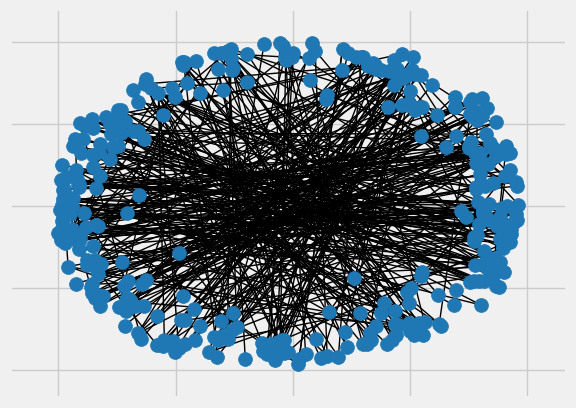

In [62]:
MST = get_MST_from_WorkloadDAG(undir_graph, 'freq')
nx.draw_networkx(MST, with_labels=False, node_size=100)

In [59]:
import networkx as nx
import math
weighted_undirected_graph = undir_graph.copy()
all_undir_edges = weighted_undirected_graph.edges(data=True)
for curr_edge in all_undir_edges:
    print(-curr_edge[2].get('execution_time', -math.inf))

-0.023
-1.249
-0.668
-485.379
-0.189
-69.064
-0.105
-0.0
-0.014
-1.335
-0.173
-0.0
-0.17
-4.879
-12.128
-187.108
-10.898
-9.013
-0.0
-0.0
-0.0
-40.398
-0.0
-435.609
-0.242
-0.093
-0.0
-0.0
-9.019
-0.0
-81.3
-0.182
-0.0
-6.707
-7.012
-5.184
-0.0
-0.0
-0.0
-28.894
-0.0
-279.867
-0.181
-0.0
-0.0
-7.763
-0.0
-62.783
-0.183
-0.0
-7.304
-4.054
-0.0
-0.0
-0.0
-32.436
-0.0
-237.433
-0.243
-0.098
-0.095
-0.094
-0.164
-0.119
-0.109
-0.097
-0.187
-0.101
-0.105
-0.247
-973.733
-0.0
-8.597
-0.0
-62.869
-313.898
-14.024
-11.022
-13.878
-11.39
-15.289
-11.513
-10.835
-13.066
-10.564
-9.666
-10.58
-9.729
-0.02
-0.246
-0.0
-0.018
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-155.855
-0.0
-0.0
-36.778
-0.009
-0.252
-0.0
-120.497
-0.008
-0.195
-0.101
-0.0
-0.0
-0.0
-0.871
-16.548
-7.035
-0.727
-0.364
-0.0
-0.0
-81.73
-0.194
-0.007
-0.0
-615.135
-0.247
-1.557
-0.206
-80.747
-0.116
-366.983
-2.094
-0.0
-0.0
-56.862
-0.116
-0.184
-286.76
-0.33
-0.0
-35.817
-0.117
-77.094
-0.798
-0.0
-0.0
-23.33
-0.122
-0.008
-69.862
-0.10

In [69]:
for tup in node_labels:
    if tup[1]['type'] == 'Agg':
        print(tup)
        print(tup[1]['data'].underlying_data)

('4A3F3862EC3739B17293F6C0469C4825', {'type': 'Agg', 'root': False, 'data': <experiment_graph.graph.node.Agg object at 0x7fd5e0a57550>, 'size': 0.0})
(246008, 122)
('86CFD76958926538A85C44814257E4D9', {'type': 'Agg', 'root': False, 'data': <experiment_graph.graph.node.Agg object at 0x7fd5e0a573a0>, 'size': 0.0})
(61503, 121)
('5F1A78DEF5005C37A39167096883035E', {'type': 'Agg', 'root': False, 'data': <experiment_graph.graph.node.Agg object at 0x7fd5dee2ad30>, 'size': 0.0})
0    226201
1     19807
Name: TARGET, dtype: int64
('D882E2920B99DDB0F79170CBE49FAFF2', {'type': 'Agg', 'root': False, 'data': <experiment_graph.graph.node.Agg object at 0x7fd578997730>, 'size': 0.0})
SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     33211
AMT_REQ_CREDIT_BUREAU_WEEK    33211
AMT_REQ_CREDIT_BUREAU_MON     3321

In [85]:
from pyvis.network import Network

net = Network(notebook=True)
node_size_transf=(lambda x: 10)
net.from_nx(MST, node_size_transf=node_size_transf)

net.show('mst.html')

mst.html


TypeError: Object of type Dataset is not JSON serializable

In [83]:
edges=MST.edges(data = True)
nodes=MST.nodes(data = True)
node_size_transf=(lambda x: 10)
if len(edges) > 0:
    for e in edges:
        print(nodes[e[0]])
        if 'size' not in nodes[e[0]].keys():
            nodes[e[0]]['size']=default_node_size
        nodes[e[0]]['size']=int(node_size_transf(nodes[e[0]]['size']))
        if 'size' not in nodes[e[1]].keys():
            nodes[e[1]]['size']=default_node_size
        nodes[e[1]]['size']=int(node_size_transf(nodes[e[1]]['size']))
#         self.add_node(e[0], **nodes[e[0]])
#         self.add_node(e[1], **nodes[e[1]])

{'root': True, 'type': 'Dataset', 'data': <experiment_graph.graph.node.Dataset object at 0x7fd1cd3b6100>, 'loc': './data/final/application_train.csv', 'extra_params': {}, 'size': None}
{'root': True, 'type': 'Dataset', 'data': <experiment_graph.graph.node.Dataset object at 0x7fd1cd3b6100>, 'loc': './data/final/application_train.csv', 'extra_params': {}, 'size': 10}
{'root': True, 'type': 'Dataset', 'data': <experiment_graph.graph.node.Dataset object at 0x7fd1cd3b6100>, 'loc': './data/final/application_train.csv', 'extra_params': {}, 'size': 10}
{'root': True, 'type': 'Dataset', 'data': <experiment_graph.graph.node.Dataset object at 0x7fd1cd3b6100>, 'loc': './data/final/application_train.csv', 'extra_params': {}, 'size': 10}
{'root': True, 'type': 'Dataset', 'data': <experiment_graph.graph.node.Dataset object at 0x7fd1cd3b6100>, 'loc': './data/final/application_train.csv', 'extra_params': {}, 'size': 10}
{'root': True, 'type': 'Dataset', 'data': <experiment_graph.graph.node.Dataset obje